## Import libraries

In [2]:
import os
import random
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import sys
import imutils
import shutil

if "../.." not in sys.path:
    sys.path.append("../..")
from custom_character_separator import get_bounding_boxes
from passport_mrz_reader.common.preprocessing import preprocess
from passport_mrz_reader.common.mrz_common import MRZ_CHARACTERS
from passport_mrz_reader.common.interfaces import PreProcessors
%load_ext autoreload

## Load images and dataset

In [3]:
base_image_path = "../../data/images/PRADO MRZ/"
data = pd.read_csv('../../data/labeled passport data.csv', index_col=0)
image_file_paths = [os.path.join(base_image_path, image_name) for image_name in data.index]
images = [np.asarray(np.asarray(Image.open(file_name))) for file_name in image_file_paths]
data.head()

,Linje 1,Linje 2
Filnavn,,
6383.jpeg,P<BELSPECIMEN<<LUCIENNE<N<S<<<<<<<<<<<<<<<<<,LA000000<7XXX5012251F0602138<<<<<<<<<<<<<<02
16971.jpeg,P<BGRIVANOVA<<RALITSA<RADNEVA<<<<<<<<<<<<<<<,0399033566BGR7608014F08080777608010133<<<<12
25899.jpeg,P<FRADUPUIS<<JEAN<<<<<<<<<<<<<<<<<<<<<<<<<<<,00ZB000002FRA6001157F1110148<<<<<<<<<<<<<<02
26843.jpeg,P<ISLAEVARSDOTTIR<<THURIDUR<OESP<<<<<<<<<<<<,A0000000<0ISL6612315F0905264311266<9539<<<32
27801.jpeg,P<SVNVZOREC<<TINA<<<<<<<<<<<<<<<<<<<<<<<<<<<,P999006213SVN6606079F10111080706966505133<52


## Test character separation on one random image 

'After resizing'

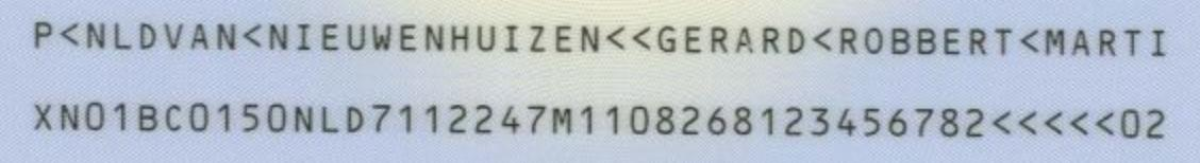

'After grayscaling'

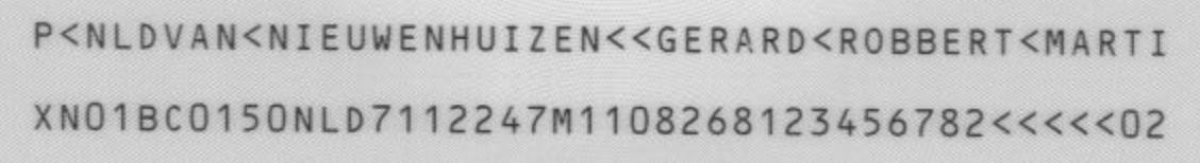

'After thresholding with threshold 10'

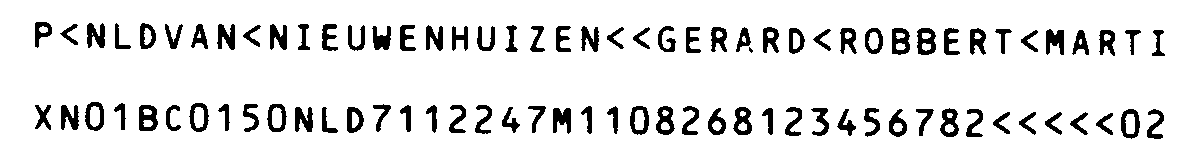

'After un-grayscaling'

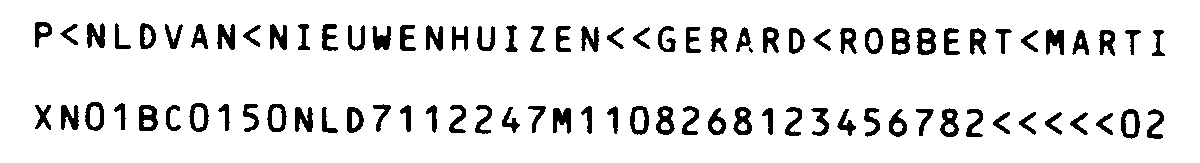

'Inverted MRZ region'

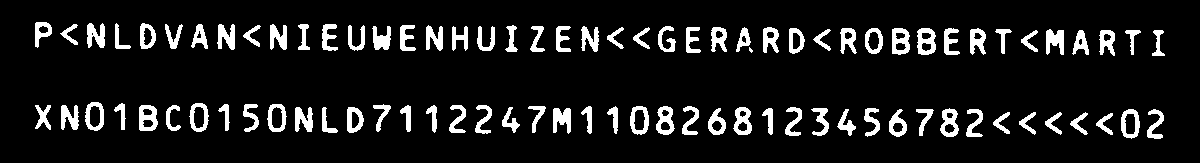

'Original bounding boxes'

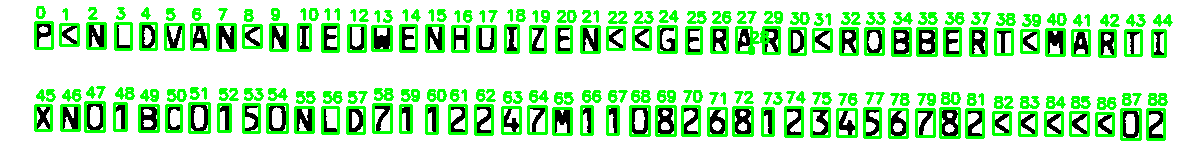

'After dropping small and large boxes'

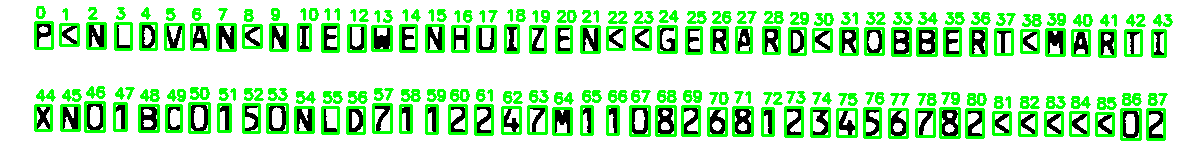

Found 88 bounding boxes


In [31]:
%autoreload
image = random.choice(images)
get_bounding_boxes(image, PreProcessors(grayscale=True, threshold=10), verbose=True);

## Create dataset with folders for each character

Should only be run once to create the dataset. The first line must be commented out to run the code.

In [36]:
#%%script false
%autoreload
# Create folders for each character
base_folder = "../../data/images/train/variable_threshold"
for character in MRZ_CHARACTERS:
    character = character if character != "<" else "less_than"
    folder = os.path.join(base_folder, character)
    if not os.path.exists(folder):
        os.makedirs(folder)

data = pd.read_csv('../../data/train.csv', index_col=0)
base_path = "../../data/images/PRADO MRZ/"
num_correct = 0
threshold_values = [10, 8, 12, 6, 14, 9, 7, 11]
for index, (file_name, row) in enumerate(data.iterrows()):
    image = np.asarray(Image.open(os.path.join(base_path, file_name)))
    image = imutils.resize(image, width=1200)
    correct_text = "".join((data.loc[file_name, 'Linje 1'], data.loc[file_name, 'Linje 2']))
    boxes = []
    i = 0
    correct = True
    while len(boxes) != len(correct_text):
        if i == len(threshold_values):
            correct = False
            break
        boxes, _ = get_bounding_boxes(image, PreProcessors(grayscale=True, threshold=threshold_values[i]), verbose=False)
        i += 1
    if correct:
        num_correct += 1
    # else: 
    #     get_bounding_boxes(image, PreProcessors(grayscale=True, threshold=threshold_values[i-1]), verbose=True)
    preprocessed_image = preprocess(image, PreProcessors(grayscale=True, threshold=threshold_values[i-1]))
    if not correct:
        continue
    for i, box in enumerate(boxes):
        correct_char = correct_text[i]
        if correct_char == "\n":
            continue
        x, y, w, h = box
        character_image = preprocessed_image[y-1:y+h+1, x-1:x+w+1]
        folder = f"{base_folder}/{correct_char if correct_char != '<' else 'less_than'}"
        try:
            cv2.imwrite(f"{folder}/{file_name.split('.')[0]}_{i}.jpeg", character_image)
        except cv2.error:
            continue
    print(f"Finished {index+1}/{len(data)} {num_correct}/{index+1} with 88 boxes", end="\r")

## Reset character folders

Will delete all images in the character folders

In [ ]:
%%script false
base_folder = "../../data/images/characters_preprocessed"
shutil.rmtree(base_folder)
os.mkdir(base_folder)
for character in MRZ_CHARACTERS:
    os.mkdir(f"{base_folder}/{character if character != '<' else 'less_than'}")